<a href="https://colab.research.google.com/github/ravindrabharathi/eip3/blob/master/ENAS_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification of CIFAR 10 dataset using ENAS discovered network 

In this exercise we will design a network for CIFAR 10 dataset using the network presented in this paper ['Efficient Neural Architecture Search via Parameter Sharing'](https://arxiv.org/pdf/1802.03268.pdf)

###Import necessary Modules 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


###create train and test data using cifar10 dataset in Keras 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


###Plot some of the images in the dataset along with class label

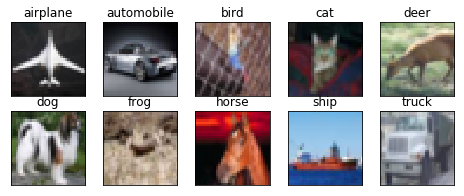

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

###define function to plot accuracy vs number of epoch and loss vs number of epochs

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

###function to return accuracy given the model, and test data

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###function to return max training accuracy given the model history 

In [0]:
def max_accuracy(model_info):
    train_acc=model_info.history['acc']
    max_train_acc=max(train_acc)
    return (max_train_acc * 100)

def max_val_accuracy(model_info):
    val_acc=model_info.history['val_acc']
    max_val_acc=max(val_acc)
    return (max_val_acc * 100)
 

###Scale the input features to be within 0 and 1 
###convert the train and test labels to 10 class category format 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Define the Model 

### The model will be designed as per the following ENAS's discovered network 
![Enas discovered Network](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/enas-network.png)

We will also consider the following points mentioned in the paper while designing the network 

###B. Details on CIFAR-10 Experiments
We find the following tricks crucial for achieving good performance with ENAS. Standard NAS (Zoph & Le, 2017;
Zoph et al., 2018) rely on these and other tricks as well.
Structure of Convolutional Layers. Each convolution in our model is applied in the order of relu-convbatchnorm (Ioffe & Szegedy, 2015; He et al., 2016b). Additionally, in our micro search space, each depthwise separable convolution is applied twice (Zoph et al., 2018).

####Stabilizing Stochastic Skip Connections. 
If a layer receives skip connections from multiple layers before it, then
these layers’ outputs are concatenated in their depth dimension, and then a convolution of filter size 1 × 1 (followed
by a batch normalization layer and a ReLU layer)

####Global Average Pooling (we will use AveragePooling with pool size same as size of incoming activation channels to mimic GAP )
After the final convolutional
layer, we average all the activations of each channel and
then pass them to the Softmax layer. We can mimic GlobalAveragePooling by using AveragePooling with pool size set to the size of the input channels

###Number of filters (mentioned in section 3.2. Image Classification on CIFAR-10 of the paper under Results (page 5))

If we keep
the architecture, but increase the number of filters in the
network’s highest layer to 512, then the test error decreases
to 3.87%, which is not far away from NAS’s best model,
whose test error is 3.65% . 

####For our network , we will follow this rule for kernel numbers   

Start with 32 filters , followed by 64 , then 128 filters and then finally 256 filters . For the last block alone we will use 64 ->128 ->256 ->512 filters.

As noted above after we concatenate ,we reduce the number of filters to follow the above rule for kernel numbers before sending the activation maps to the next layer 





In [0]:
#layers are connected as follows
#layer no. | incoming
#4         - 1,3  
#mp1       - 1,4
#6         - 1,4,mp1
#7         - 3,4,5,6
#8         - 6, 3, 5, 4,1,7
#mp2       - 7, 5,1,4 ,8
#9         -6
#10        - 2,7,4,9
#11        - 2,3, 5,10
#12        - 10,7,3,4,5,1,11
#smax      - 4,7,10,12


# space to depth functions to transform shape in order to concatenate 
# since spatial dimensions need to match while concatenating

def space_to_depth_x2(x,block_size=2):
    import tensorflow as tf
    return tf.space_to_depth(x, block_size)
  
def space_to_depth_x4(x,block_size=4):
    import tensorflow as tf
    return tf.space_to_depth(x, block_size) 
  


In [0]:
from keras.layers.convolutional import Conv2D
from keras.layers import Input, SeparableConv2D,BatchNormalization, Lambda ,AveragePooling2D,Dropout
from keras.layers.advanced_activations import ReLU
from keras.models import Model,  load_model
from keras.layers.merge import concatenate

In [0]:
#BUILD THE MODEL

#input layer size 32 x 32 and 3 color channels 
input_layer = Input(shape=(32, 32, 3))


#depthwise separable conv2d , size 5
layer1 = SeparableConv2D(64, 5,padding='same', name='layer1' ) (input_layer) 

layer1 = BatchNormalization(name='BN1')(layer1)
layer1 = ReLU(name='R1')(layer1)

#conv2d size 5
layer2=Conv2D(128,5, padding='same', name='layer2') (layer1)

layer2=BatchNormalization(name='BN2')(layer2)
layer2=ReLU(name='R2')(layer2)


#conv2d size 5
layer3=Conv2D(256,5, padding='same',name='layer3') (layer2)

layer3=BatchNormalization(name='BN3')(layer3)
layer3=ReLU(name='R3')(layer3)

#concatenate layers wherever a skip connection has been show 
sc1=concatenate([layer1,layer3],name='sc1')

#reduce the channel numbers after concatenation to follow the 64->128->256->512 rule before sending to next layer 
reducer1=Conv2D(256, 1,name='red1' )(sc1)
reducer1=BatchNormalization(name='RBN1')(reducer1)
reducer1 = ReLU(name='RR1')(reducer1)

#depthwise separable conv2d , size 5
layer4 = SeparableConv2D(512, 5, padding='same',name='layer4' ) (reducer1) 

layer4 = BatchNormalization(name='BN4')(layer4)
layer4 = ReLU(name='R4')(layer4)

sc2=concatenate([layer1,layer4],name='sc2')

d1=Dropout(0.15)(sc2)

reducer2=Conv2D(512, 1,name='red2' )(d1)
reducer2=BatchNormalization(name='RBN2')(reducer2)
reducer2 = ReLU(name='RR2')(reducer2)

MP1=MaxPooling2D(pool_size=(2, 2),name='MP1')(reducer2)    

reducer21=Conv2D(64, 1,name='red21' )(MP1)
reducer21=BatchNormalization(name='RBN21')(reducer21)
reducer21 = ReLU(name='RR21')(reducer21)


layer5 = SeparableConv2D(64, 3, padding='same',name='layer5' ) (reducer21) 

layer5 = BatchNormalization(name='BN5')(layer5)
layer5 = ReLU(name='R5')(layer5)

sc3=concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),layer5],name='sc3')

reducer3=Conv2D(64, 1,name='red3' )(sc3)
reducer3=BatchNormalization(name='RBN3')(reducer3)
reducer3 = ReLU(name='RR3')(reducer3)

layer6=Conv2D(128,5, padding='same', name='layer6') (reducer3)

layer6=BatchNormalization(name='BN6')(layer6)
layer6=ReLU(name='R6')(layer6)

sc4 = concatenate([Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),layer5,layer6],name='sc4')

reducer4=Conv2D(128, 1,name='red4' )(sc4)
reducer4=BatchNormalization(name='RBN4')(reducer4)
reducer4 = ReLU(name='RR4')(reducer4)

layer7=SeparableConv2D(256,3,padding='same', name='layer7') (reducer4)

layer7=BatchNormalization(name='BN7')(layer7)
layer7=ReLU(name='R7')(layer7)

sc5 = concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer6,layer7],name='sc5')

reducer5=Conv2D(256, 1,name='red5' )(sc5)
reducer5=BatchNormalization(name='RBN5')(reducer5)
reducer5 = ReLU(name='RR5')(reducer5)

layer8 = SeparableConv2D(512, 5, padding='same',name='layer8' ) (reducer5) 

layer8 = BatchNormalization(name='BN8')(layer8)
layer8 = ReLU(name='R8')(layer8)

sc6=  concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer7,layer8],name='sc6')

d2=Dropout(0.15)(sc6)


reducer6=Conv2D(512, 1,name='red6' )(d2)
reducer6=BatchNormalization(name='RBN6')(reducer6)
reducer6 = ReLU(name='RR6')(reducer6)


MP2=MaxPooling2D(pool_size=(2, 2),name='MP2')(reducer6) 



sc7= concatenate([Lambda(space_to_depth_x2)(layer6),MP2])

reducer7=Conv2D(64, 1,name='red7' )(sc7)
reducer7=BatchNormalization(name='RBN7')(reducer7)
reducer7 = ReLU(name='RR7')(reducer7)

layer9=Conv2D(64,5,  padding='same',name='layer9') (reducer7)

layer9=BatchNormalization(name='BN9')(layer9)
layer9=ReLU(name='R9')(layer9)

sc8 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7),
                   layer9],name='sc8')

reducer8=Conv2D(64, 1,name='red8' )(sc8)
reducer8=BatchNormalization(name='RBN8')(reducer8)
reducer8 = ReLU(name='RR8')(reducer8)

layer10 = SeparableConv2D(128, 5, padding='same',name='layer10' ) (reducer8) 

layer10 = BatchNormalization(name='BN10')(layer10)
layer10 = ReLU(name='R10')(layer10)


sc9 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x2)(layer5),layer10],name='sc9')
 

reducer9=Conv2D(128, 1,name='red9' )(sc9)
reducer9=BatchNormalization(name='RBN9')(reducer9)
reducer9 = ReLU(name='RR9')(reducer9)  
  
layer11=Conv2D(256,3, padding='same',name='layer11') (reducer9)

layer11=BatchNormalization(name='BN11')(layer11)
layer11=ReLU(name='R11')(layer11)



sc10 = concatenate([Lambda(space_to_depth_x4)(layer1),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x4)(layer4),Lambda(space_to_depth_x2)(layer5),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer11],name='sc10')

reducer10=Conv2D(256, 1,name='red10' )(sc10)
reducer10=BatchNormalization(name='RBN10')(reducer10)
reducer10= ReLU(name='RR10')(reducer10)

layer12 = SeparableConv2D(512, 5, padding='same',name='layer12' ) (reducer10) 

layer12 = BatchNormalization(name='BN12')(layer12)
layer12 = ReLU(name='R12')(layer12)


sc11= concatenate([Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer12],name='sc11')


#Pointwise convolution to squash incoming channels to 10 output channels 
layer13=(Conv2D(10,1, name='layer13'))(sc11)

layer13 = BatchNormalization(name='BN13')(layer13)
layer13 = ReLU(name='R13')(layer13)

# We are at a point where the activation channels have a spatial size of 8x8 . We do not want to use a 8x8 conv layer 

# Instead we will add Average Pooling with pool size same as the input in order to mimic Global Average Pooling 

layer14 = AveragePooling2D(pool_size=(8,8), name='layer15')(layer13) 

#Flatten the output 
flat_layer=(Flatten(name='flat_layer'))(layer14)

#Softmax activation to output likelihood values for classes 

output=Activation('softmax')(flat_layer)

#Assign the Model input and output

model = Model(inputs=[input_layer], outputs=[output])



W0616 10:51:27.555552 140672241686400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 10:51:27.600115 140672241686400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 10:51:27.608476 140672241686400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 10:51:27.659118 140672241686400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 10:51:27.660497 1406722416

####plot the model as a png image and display it 



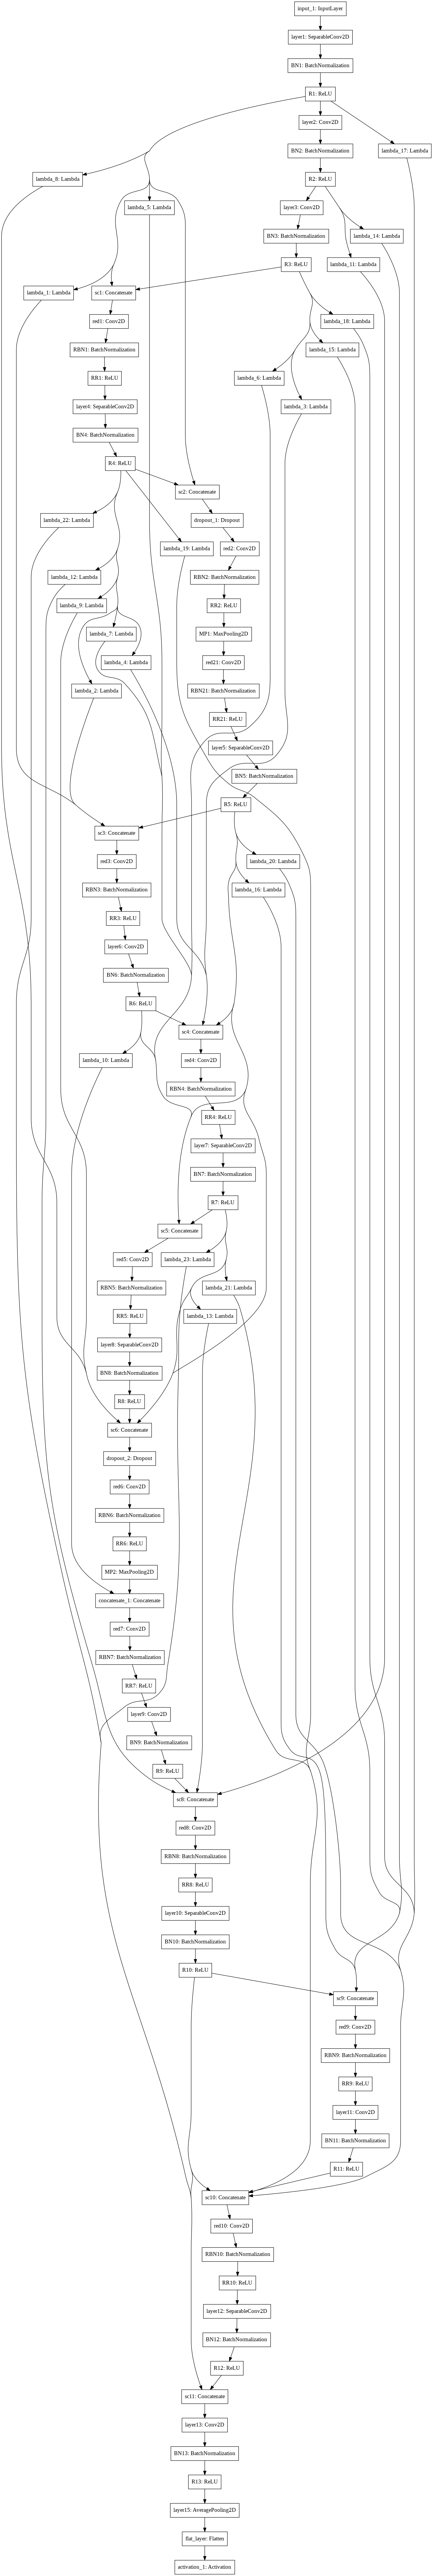

In [0]:
#plot the model as a png image and display it 

from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image, display
display(Image('model.png',width=1000,height=3000))

####print model summary

In [0]:
#Print model summary 
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer1 (SeparableConv2D)        (None, 32, 32, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 32, 32, 64)   256         layer1[0][0]                     
__________________________________________________________________________________________________
R1 (ReLU)                       (None, 32, 32, 64)   0           BN1[0][0]                        
__________________________________________________________________________________________________
layer2 (Co

###Learning Rate Scheduler : 
####We will add a custom learning rate scheduler that reduces the rate every 2nd epoch sugject to a min of 0.0001. We will also start with a slightly larger lr of 0.003 compared to default of 0.001 for Adam optimizer. 

####Reducing Learning rate only when training plateaus is a better option compared to what we are doing here 

In [0]:
# define a learning rate scheduler . We will use a simple scheduler that reduces the lr by 10% every 3 epochs subject to a minimum lr of 0.0001 
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%2==0 and epoch):
    new_lr = max(0.9*lr,0.0001) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)
  
 



In [0]:
from google.colab import drive

drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from keras.callbacks import ModelCheckpoint

chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/session7/model_custom_cifar10_best.h5", monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
#comile model with Adam optimizer , start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

W0616 10:53:04.926007 140672241686400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



###Image Augmentation : 
In order to help the network generalize better , we will augment the training image samples by using image augmentation techniques. We will add some transforms in  random combinations like a zoom factor, a small shift of image , rotation by a small range and flipping the image horizontally. To do this we will use an ImageDataGenerator 

#### Define Imagedatagenerator with horizontal flip set to True ,zoom range of 0.10, shift image along width by a range of 0.1 , shift image along height  by a range of 0.1 and rotate image by 10 degrees . All these will be applied in random combinations 

We will then : 

#### Train the model for 100 epochs 
#### Plot accuracy vs number of epochs 
#### Plot loss vs number of epochs 
#### print validation accuracy
#### print max training accuracy 
#### print max validation accuracy 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=5)`
  if sys.path[0] == '':


Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 349s 896ms/step - loss: 0.9274 - acc: 0.6902 - val_loss: 1.3998 - val_acc: 0.5413
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 355s 910ms/step - loss: 0.6848 - acc: 0.7718 - val_loss: 1.3750 - val_acc: 0.5668
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0027.
390/390 [==============================] - 348s 892ms/step - loss: 0.5279 - acc: 0.8258 - val_loss: 1.2394 - val_acc: 0.6023
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0027000001.
390/390 [==============================] - 348s 891ms/step - loss: 0.4129 - acc: 0.8665 - val_loss: 1.1221 - val_acc: 0.6448
Epoch 5/5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0024300001.
390/390 [==============================] - 347s 890ms/step - loss: 0.3093 - acc: 0.9001 - val_l

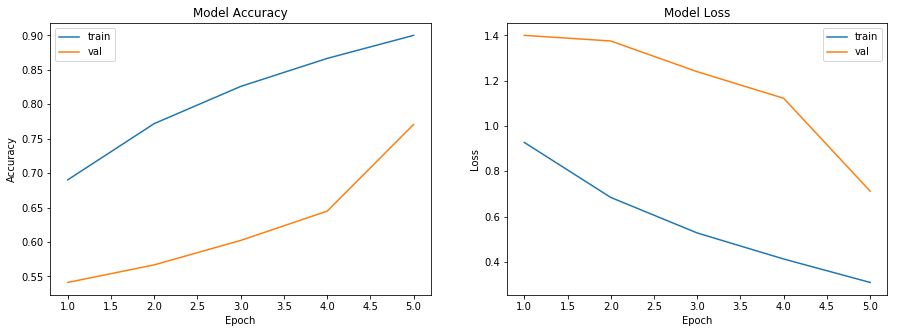


Accuracy on test data is: 77.07

Max Training Accuracy on training data is: 90.00

Max Validation Accuracy on test data is: 77.07


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 5, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=35)`
  del sys.path[0]


Epoch 1/35

Epoch 00001: LearningRateScheduler setting learning rate to 0.0024300001.
390/390 [==============================] - 348s 892ms/step - loss: 0.5277 - acc: 0.8229 - val_loss: 1.0428 - val_acc: 0.6893
Epoch 2/35

Epoch 00002: LearningRateScheduler setting learning rate to 0.0024300001.
390/390 [==============================] - 347s 890ms/step - loss: 0.4622 - acc: 0.8443 - val_loss: 0.8085 - val_acc: 0.7368
Epoch 3/35

Epoch 00003: LearningRateScheduler setting learning rate to 0.0021870001.
390/390 [==============================] - 347s 890ms/step - loss: 0.4109 - acc: 0.8617 - val_loss: 0.4694 - val_acc: 0.8425
Epoch 4/35

Epoch 00004: LearningRateScheduler setting learning rate to 0.0021870001.
390/390 [==============================] - 347s 890ms/step - loss: 0.3765 - acc: 0.8740 - val_loss: 0.8488 - val_acc: 0.7494
Epoch 5/35

Epoch 00005: LearningRateScheduler setting learning rate to 0.0019683001.
390/390 [==============================] - 347s 890ms/step - loss: 0.3

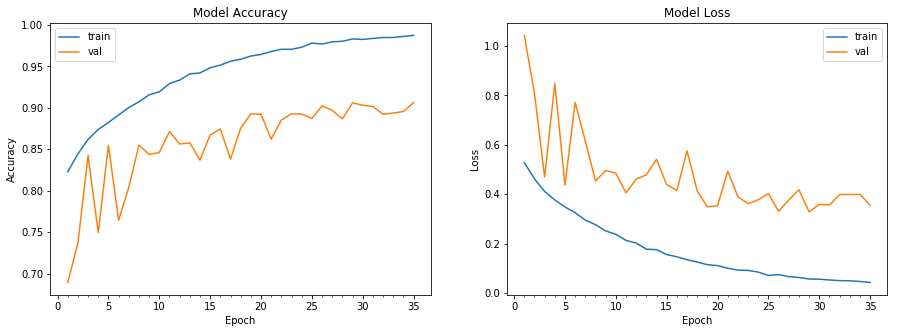


Accuracy on test data is: 90.64

Max Training Accuracy on training data is: 98.74

Max Validation Accuracy on test data is: 90.64


In [0]:


datagen = ImageDataGenerator(zoom_range=0.1, 
                             horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1,rotation_range=10)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 35, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0004052555.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=10)`
  if sys.path[0] == '':


390/390 [==============================] - 346s 887ms/step - loss: 0.0133 - acc: 0.9973 - val_loss: 0.2890 - val_acc: 0.9206
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0004052555.
390/390 [==============================] - 346s 886ms/step - loss: 0.0089 - acc: 0.9988 - val_loss: 0.2919 - val_acc: 0.9188
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.00036473.
390/390 [==============================] - 346s 887ms/step - loss: 0.0071 - acc: 0.9993 - val_loss: 0.2843 - val_acc: 0.9210
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.00036473.
390/390 [==============================] - 346s 886ms/step - loss: 0.0060 - acc: 0.9994 - val_loss: 0.2953 - val_acc: 0.9204
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.000328257.
390/390 [==============================] - 346s 886ms/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.2907 - val_acc: 0.9180
Epoch 6/10

Epoch 00006: LearningRat

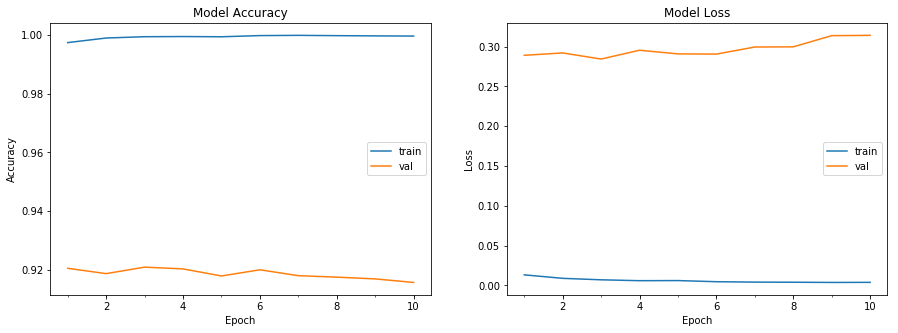


Accuracy on test data is: 91.58

Max Training Accuracy on training data is: 99.98

Max Validation Accuracy on test data is: 92.10


In [22]:


datagen = ImageDataGenerator(horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002658882.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=5)`
  if sys.path[0] == '':


390/390 [==============================] - 346s 887ms/step - loss: 0.0033 - acc: 0.9997 - val_loss: 0.3104 - val_acc: 0.9167
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002658882.
390/390 [==============================] - 346s 887ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.3113 - val_acc: 0.9200
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0002392994.
390/390 [==============================] - 346s 886ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.3246 - val_acc: 0.9168
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0002392994.
390/390 [==============================] - 346s 887ms/step - loss: 0.0019 - acc: 0.9999 - val_loss: 0.3153 - val_acc: 0.9195
Epoch 5/5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0002153695.
390/390 [==============================] - 346s 887ms/step - loss: 0.0020 - acc: 0.9999 - val_loss: 0.3352 - val_acc: 0.9174
Model took 1729.43 seconds to train

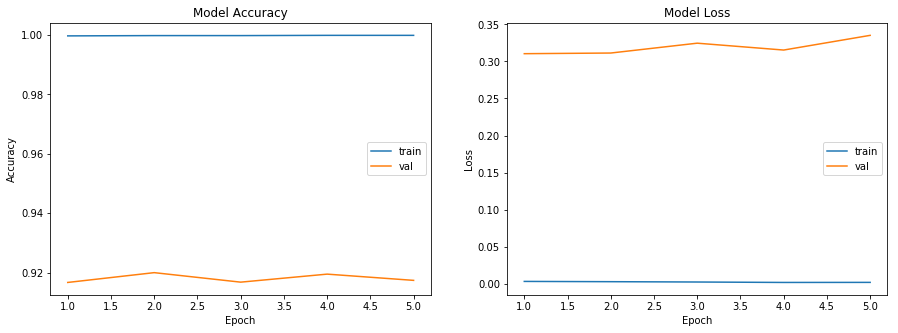


Accuracy on test data is: 91.74

Max Training Accuracy on training data is: 99.99

Max Validation Accuracy on test data is: 92.00


In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 5, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0002153695.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=10)`
  if sys.path[0] == '':


390/390 [==============================] - 347s 890ms/step - loss: 0.0394 - acc: 0.9874 - val_loss: 0.3844 - val_acc: 0.9017
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0002153695.
390/390 [==============================] - 346s 888ms/step - loss: 0.0267 - acc: 0.9920 - val_loss: 0.3970 - val_acc: 0.9007
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001938325.
390/390 [==============================] - 346s 888ms/step - loss: 0.0225 - acc: 0.9934 - val_loss: 0.4086 - val_acc: 0.8983
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001938325.
390/390 [==============================] - 347s 889ms/step - loss: 0.0212 - acc: 0.9939 - val_loss: 0.3897 - val_acc: 0.9036
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001744493.
390/390 [==============================] - 346s 888ms/step - loss: 0.0192 - acc: 0.9949 - val_loss: 0.3828 - val_acc: 0.9033
Epoch 6/10

Epoch 00006: Learni

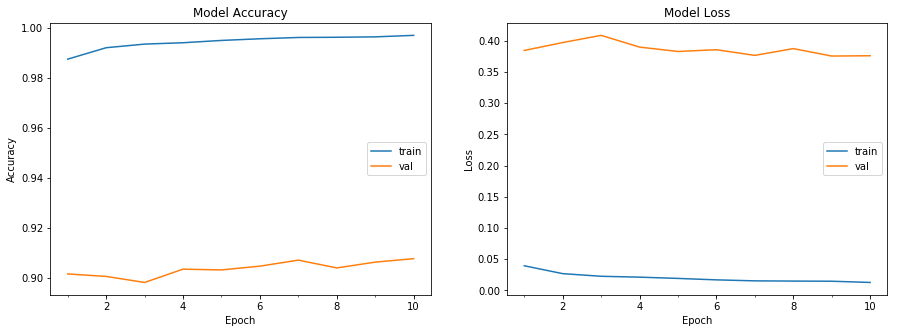


Accuracy on test data is: 90.78

Max Training Accuracy on training data is: 99.69

Max Validation Accuracy on test data is: 90.78


In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.15, height_shift_range=0.15)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.000141304.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=10)`
  del sys.path[0]


390/390 [==============================] - 347s 889ms/step - loss: 0.0195 - acc: 0.9943 - val_loss: 0.3617 - val_acc: 0.9082
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.000141304.
390/390 [==============================] - 346s 888ms/step - loss: 0.0157 - acc: 0.9958 - val_loss: 0.3659 - val_acc: 0.9103
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001271736.
390/390 [==============================] - 346s 888ms/step - loss: 0.0153 - acc: 0.9959 - val_loss: 0.3596 - val_acc: 0.9096
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001271736.
390/390 [==============================] - 347s 889ms/step - loss: 0.0151 - acc: 0.9957 - val_loss: 0.3381 - val_acc: 0.9126
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001144562.
390/390 [==============================] - 346s 888ms/step - loss: 0.0137 - acc: 0.9964 - val_loss: 0.3465 - val_acc: 0.9120
Epoch 6/10

Epoch 00006: Learnin

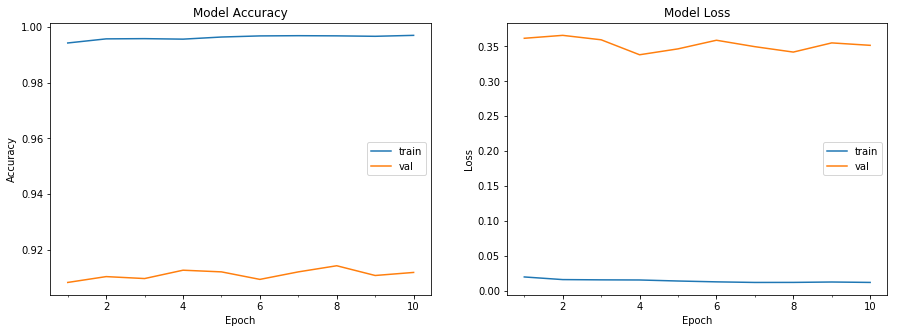


Accuracy on test data is: 91.18

Max Training Accuracy on training data is: 99.70

Max Validation Accuracy on test data is: 91.42


In [25]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, 
                             horizontal_flip=True,rotation_range=10)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=15)`
  del sys.path[0]


390/390 [==============================] - 347s 889ms/step - loss: 0.0202 - acc: 0.9939 - val_loss: 0.3606 - val_acc: 0.9088
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 347s 888ms/step - loss: 0.0180 - acc: 0.9947 - val_loss: 0.3616 - val_acc: 0.9095
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 346s 887ms/step - loss: 0.0182 - acc: 0.9947 - val_loss: 0.3638 - val_acc: 0.9088
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 347s 889ms/step - loss: 0.0177 - acc: 0.9950 - val_loss: 0.3690 - val_acc: 0.9082
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 346s 888ms/step - loss: 0.0177 - acc: 0.9949 - val_loss: 0.3671 - val_acc: 0.9089
Epoch 6/15

Epoch 00006: LearningRateScheduler setting 

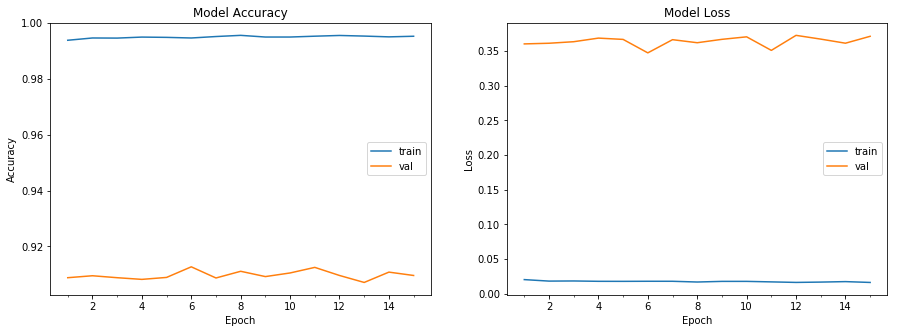


Accuracy on test data is: 90.96

Max Training Accuracy on training data is: 99.57

Max Validation Accuracy on test data is: 91.27


In [26]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, 
                             horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1,rotation_range=10)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 15, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=10)`
  if sys.path[0] == '':


390/390 [==============================] - 346s 888ms/step - loss: 0.0018 - acc: 0.9999 - val_loss: 0.3006 - val_acc: 0.9206
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 346s 887ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.3014 - val_acc: 0.9204
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 346s 887ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3007 - val_acc: 0.9217
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 346s 887ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.3006 - val_acc: 0.9210
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
390/390 [==============================] - 346s 887ms/step - loss: 9.9810e-04 - acc: 1.0000 - val_loss: 0.3021 - val_acc: 0.9217
Epoch 6/10

Epoch 00006: LearningRateScheduler sett

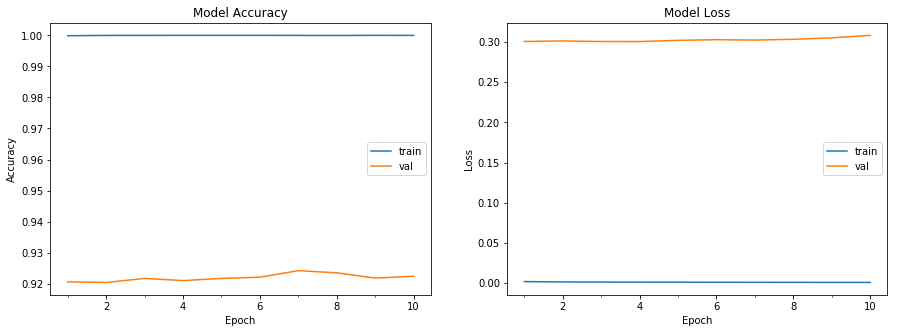


Accuracy on test data is: 92.24

Max Training Accuracy on training data is: 100.00

Max Validation Accuracy on test data is: 92.42


In [27]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1),chkpoint_model],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))
print ("\nMax Validation Accuracy on test data is: %0.2f"%max_val_accuracy(model_info))

### We trained the model for 100 epochs and it reached a max validation accuracy of 90.89. 
#### we will ignore the error in printing max val accuracy due to time constraints 

##Model With Lesser Parameters 

Let us change the kernel numbers in the model to reduce the number of parameters and see if there is any performance hit 

We will change the model such that all but the last block starts with 8 kernels and goes upto 128 kernels (8->16->32->128). Only the last block will be 16->32->64->128 . The rest of the elements in the network remain the same .

In [0]:


#input layer size 32 x 32 and 3 color channels 
input_layer = Input(shape=(32, 32, 3))


#depthwise separable conv2d , size 5
layer1 = SeparableConv2D(8, 5,padding='same', name='layer1' ) (input_layer) 

layer1 = BatchNormalization(name='BN1')(layer1)
layer1 = ReLU(name='R1')(layer1)

#conv2d size 5
layer2=Conv2D(16,5, padding='same', name='layer2') (layer1)

layer2=BatchNormalization(name='BN2')(layer2)
layer2=ReLU(name='R2')(layer2)


#conv2d size 5
layer3=Conv2D(32,5, padding='same',name='layer3') (layer2)

layer3=BatchNormalization(name='BN3')(layer3)
layer3=ReLU(name='R3')(layer3)

sc1=concatenate([layer1,layer3],name='sc1')

reducer1=Conv2D(32, 1,name='red1' )(sc1)
reducer1=BatchNormalization(name='RBN1')(reducer1)
reducer1 = ReLU(name='RR1')(reducer1)

#depthwise separable conv2d , size 5
layer4 = SeparableConv2D(64, 5, padding='same',name='layer4' ) (reducer1) 

layer4 = BatchNormalization(name='BN4')(layer4)
layer4 = ReLU(name='R4')(layer4)

sc2=concatenate([layer1,layer4],name='sc2')

reducer2=Conv2D(8, 1,name='red2' )(sc2)
reducer2=BatchNormalization(name='RBN2')(reducer2)
reducer2 = ReLU(name='RR2')(reducer2)

MP1=MaxPooling2D(pool_size=(2, 2),name='MP1')(reducer2)                          


layer5 = SeparableConv2D(8, 3, padding='same',name='layer5' ) (MP1) 

layer5 = BatchNormalization(name='BN5')(layer5)
layer5 = ReLU(name='R5')(layer5)

sc3=concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),layer5],name='sc3')

reducer3=Conv2D(8, 1,name='red3' )(sc3)
reducer3=BatchNormalization(name='RBN3')(reducer3)
reducer3 = ReLU(name='RR3')(reducer3)

layer6=Conv2D(16,5, padding='same', name='layer6') (reducer3)

layer6=BatchNormalization(name='BN6')(layer6)
layer6=ReLU(name='R6')(layer6)

sc4 = concatenate([Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),layer5,layer6],name='sc4')

reducer4=Conv2D(16, 1,name='red4' )(sc4)
reducer4=BatchNormalization(name='RBN4')(reducer4)
reducer4 = ReLU(name='RR4')(reducer4)

layer7=SeparableConv2D(32,3,padding='same', name='layer7') (reducer4)

layer7=BatchNormalization(name='BN7')(layer7)
layer7=ReLU(name='R7')(layer7)

sc5 = concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer3),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer6,layer7],name='sc5')

reducer5=Conv2D(32, 1,name='red5' )(sc5)
reducer5=BatchNormalization(name='RBN5')(reducer5)
reducer5 = ReLU(name='RR5')(reducer5)

layer8 = SeparableConv2D(64, 5, padding='same',name='layer8' ) (reducer5) 

layer8 = BatchNormalization(name='BN8')(layer8)
layer8 = ReLU(name='R8')(layer8)

sc6=  concatenate([Lambda(space_to_depth_x2)(layer1),Lambda(space_to_depth_x2)(layer4),
                   layer5,layer7,layer8],name='sc6')

reducer6=Conv2D(16, 1,name='red6' )(sc6)
reducer6=BatchNormalization(name='RBN6')(reducer6)
reducer6 = ReLU(name='RR6')(reducer1)


MP2=MaxPooling2D(pool_size=(2, 2),name='MP2')(sc6)  

sc7= concatenate([Lambda(space_to_depth_x2)(layer6),MP2])

reducer7=Conv2D(16, 1,name='red7' )(sc7)
reducer7=BatchNormalization(name='RBN7')(reducer7)
reducer7 = ReLU(name='RR7')(reducer7)

layer9=Conv2D(16,5,  padding='same',name='layer9') (reducer7)

layer9=BatchNormalization(name='BN9')(layer9)
layer9=ReLU(name='R9')(layer9)

sc8 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7),
                   layer9],name='sc8')

reducer8=Conv2D(16, 1,name='red8' )(sc8)
reducer8=BatchNormalization(name='RBN8')(reducer8)
reducer8 = ReLU(name='RR8')(reducer8)

layer10 = SeparableConv2D(32, 5, padding='same',name='layer10' ) (reducer8) 

layer10 = BatchNormalization(name='BN10')(layer10)
layer10 = ReLU(name='R10')(layer10)


sc9 = concatenate([Lambda(space_to_depth_x4)(layer2),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x2)(layer5),layer10],name='sc9')
 

reducer9=Conv2D(32, 1,name='red9' )(sc9)
reducer9=BatchNormalization(name='RBN9')(reducer9)
reducer9 = ReLU(name='RR9')(reducer9)  
  
layer11=Conv2D(64,3, padding='same',name='layer11') (reducer9)

layer11=BatchNormalization(name='BN11')(layer11)
layer11=ReLU(name='R11')(layer11)



sc10 = concatenate([Lambda(space_to_depth_x4)(layer1),Lambda(space_to_depth_x4)(layer3),
                   Lambda(space_to_depth_x4)(layer4),Lambda(space_to_depth_x2)(layer5),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer11],name='sc10')

reducer10=Conv2D(64, 1,name='red10' )(sc10)
reducer10=BatchNormalization(name='RBN10')(reducer10)
reducer10= ReLU(name='RR10')(reducer10)

layer12 = SeparableConv2D(128, 5, padding='same',name='layer12' ) (reducer10) 

layer12 = BatchNormalization(name='BN12')(layer12)
layer12 = ReLU(name='R12')(layer12)


sc11= concatenate([Lambda(space_to_depth_x4)(layer4),
                   Lambda(space_to_depth_x2)(layer7), layer10,layer12],name='sc11')


#Pointwise convolution to squash incoming channels to 10 output channels 
layer13=(Conv2D(10,1, name='layer13'))(sc11)

layer13 = BatchNormalization(name='BN13')(layer13)
layer13 = ReLU(name='R13')(layer13)

# We are at a point where the activation channels have a spatial size of 8x8 . We do not want to use a 8x8 conv layer 

# Instead we will add Average Pooling with pool size same as the input in order to mimic Global Average Pooling 

layer14 = AveragePooling2D(pool_size=(8,8), name='layer15')(layer13) 

#Flatten the output 
flat_layer=(Flatten(name='flat_layer'))(layer14)

#Softmax activation to output likelihood values for classes 

output=Activation('softmax')(flat_layer)

#Assign the Model input and output

model = Model(inputs=[input_layer], outputs=[output])

###plot the model as a png image and display it 

In [0]:
#plot the model as a png image and display it 

from keras.utils import plot_model
plot_model(model, to_file='model2.png')

from IPython.display import Image, display
display(Image('model2.png',width=1000,height=3000))

####print model summary

In [0]:
model.summary()

### define learning rate scheduler

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%3==0 and epoch):
    new_lr = max(0.90*lr,0.0001) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)

####compile model 

In [0]:
#start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

###Image Augmentation : 
#### Define Imagedatagenerator with horizontal flip set to True ,zoom range of 0.10, shift image along width by a range of 0.1 , shift image along height by a range of 0.1 and rotate image by 10 degrees . All these will be applied in random combinations
#### Train the model for 100 epochs 
#### Plot accuracy vs number of epochs 
#### Plot loss vs number of epochs 
#### print validation accuracy
#### print max training accuracy 
 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, 
                             horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1,rotation_range=10)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[LearningRateScheduler(scheduler, verbose=1)],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train\n"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("\nAccuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
print ("\nMax Training Accuracy on training data is: %0.2f"%max_accuracy(model_info))


### We built a model following the ENAS' discovered architecture 

### We added the following to help the network learn optimally and avoid overfitting: 
###BatchNormalization and Image Augmentation 

### We added a simple learning rate scheduler (ideally we should use a scheduler that changes LR on plateau) to help the network converge faster and avoid getting stuck at one learning rate

### For the last layer we added AveragePooling with size equal to size of the input channel to mimic Global Average Pooling 

### The first model with 4,021,885 parameters trained for 100 epochs and reached a max validation accuracy of 90.89

### The lighter model with 266,557 parameters trained for 100 epochs and reached a max validation accuracy of 86.42 in the 89th Epoch